In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, \
recall_score, cohen_kappa_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
events = pd.read_csv("C:/Users/byeongwan/OneDrive/desktop/archive/events.csv")
info = pd.read_csv("C:/Users/byeongwan/OneDrive/desktop/archive/ginf.csv")

In [4]:
# We add to our events dataset useful information from the ginf.csv, such as the league/country and the date

events = events.merge(info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')
extract_year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
events['year'] = [extract_year(x) for key, x in enumerate(events['date'])]

In [5]:
# We create a new dataset named Shots that will contain everything related to this action of the game and exclude the rest.

shots = events[events.event_type==1]
shots['player'] = shots['player'].str.title()
shots['player2'] = shots['player2'].str.title()
shots['country'] = shots['country'].str.title()

C:\Users\BYEONG~1\AppData\Local\Temp/ipykernel_20488/630113131.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['player'] = shots['player'].str.title()
C:\Users\BYEONG~1\AppData\Local\Temp/ipykernel_20488/630113131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['player2'] = shots['player2'].str.title()
C:\Users\BYEONG~1\AppData\Local\Temp/ipykernel_20488/630113131.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [6]:
events.head(10)

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,country,date,year
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0,germany,2011-08-05,2011
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0,germany,2011-08-05,2011
5,UFot0hit/,UFot0hit6,6,9,Hand ball by Jose Paolo Guerrero (Hamburg).,10,NaN,2,Hamburg SV,Borussia Dortmund,jose paolo guerrero,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
6,UFot0hit/,UFot0hit7,7,10,"Corner, Hamburg. Conceded by Lukasz Piszczek.",2,NaN,2,Hamburg SV,Borussia Dortmund,lukasz piszczek,lukasz piszczek,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
7,UFot0hit/,UFot0hit8,8,11,Chris Lowe (Borussia Dortmund) wins a free kic...,8,NaN,1,Borussia Dortmund,Hamburg SV,chris lowe,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0,germany,2011-08-05,2011
8,UFot0hit/,UFot0hit9,9,11,Foul by Gojko Kacar (Hamburg).,3,NaN,2,Hamburg SV,Borussia Dortmund,gojko kacar,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011
9,UFot0hit/,UFot0hit10,10,13,Foul by Gokhan Tore (Hamburg).,3,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,germany,2011-08-05,2011


In [7]:
events.shape

(941009, 25)

In [8]:
info.head(10)

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN
5,lOpzwMkp/,/soccer/germany/bundesliga-2011-2012/hertha-be...,True,2011-08-06,D1,2012,germany,Hertha Berlin,Nurnberg,0,1,2.06,3.75,3.95,NaN,NaN,NaN,NaN
6,M7PhlM2C/,/soccer/france/ligue-1-2011-2012/brest-evian-t...,True,2011-08-06,F1,2012,france,Brest,Evian Thonon Gaillard,2,2,2.29,3.25,3.85,NaN,NaN,NaN,NaN
7,QuWqjrYa/,/soccer/france/ligue-1-2011-2012/ac-ajaccio-to...,True,2011-08-06,F1,2012,france,AC Ajaccio,Toulouse,0,2,2.80,3.10,3.05,NaN,NaN,NaN,NaN
8,UBZQ4smg/,/soccer/france/ligue-1-2011-2012/nice-lyon-UBZ...,True,2011-08-06,F1,2012,france,Nice,Lyon,1,3,4.50,3.55,2.00,NaN,NaN,NaN,NaN
9,Wn69eU5B/,/soccer/germany/bundesliga-2011-2012/koln-wolf...,True,2011-08-06,D1,2012,germany,FC Cologne,VfL Wolfsburg,0,3,3.00,3.80,2.54,NaN,NaN,NaN,NaN


In [9]:
info.shape

(10112, 18)

In [10]:
pie = shots[['shot_outcome', 'id_event']].groupby('shot_outcome').count().reset_index().rename(columns={'id_event': 'count'})

In [11]:
pie.shot_outcome = pie.shot_outcome.astype(int)
pie.shot_outcome = pie.shot_outcome.replace({1: 'On Target', 2: 'Off Target', 3: 'Blocked', 4: 'Hit the Bar'})

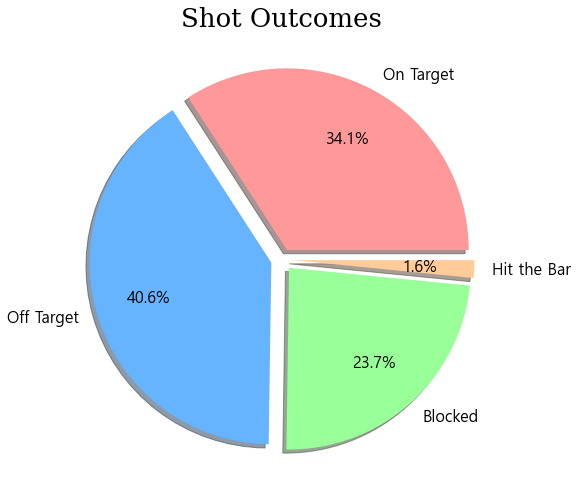

In [12]:
fig, ax = plt.subplots(figsize=[8,8])
labels = pie['shot_outcome']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=pie['count'], autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
       textprops=dict(fontsize=16))
plt.title("Shot Outcomes", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

In [13]:
bar = shots[['shot_place', 'id_event']].groupby('shot_place').count().reset_index().rename(columns={'id_event': 'count'})

bar.shot_place = bar.shot_place.astype(int)

bar.shot_place = bar.shot_place.replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                                        5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                                        9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                                        12: 'Top left corner', 13: 'Top right corner'})

C:\Users\BYEONG~1\AppData\Local\Temp/ipykernel_20488/2856602406.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, size = 13)


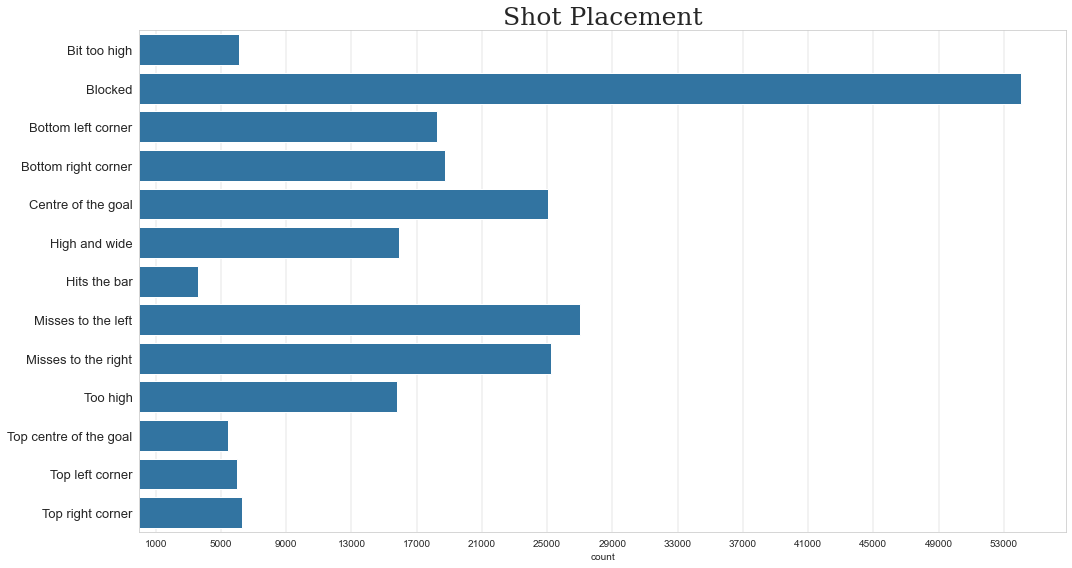

In [14]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[15,8])
labels = bar['shot_place']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=bar['count'], y=labels)
ax.set_yticklabels(labels, size = 13)
ax.set_xticks(np.arange(1000,57000,4000))
ax.set_ylabel(ylabel='')
plt.title("Shot Placement", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

In [15]:
# We'll explore something that will be important for our xG model: which percentage of shots end up as goals. We'll divide this analysis for the different leagues and across years, to check if there are differences in the patterns through different parts of the world or different years.

goals  = shots[['is_goal', 'id_event', 'country']].groupby(['is_goal', 'country']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})